Name: Yuk Fai Wong\
StudentID: n10670815\
IFN619 Assessment 1B\
Question3:\
What were the top Australian news topics over the last decade, and what can these say about the national conversation?

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import random
import copy
from IPython.display import HTML, display

import swifter
import spacy
import multiprocess


import multiprocessing
cpu = int(multiprocessing.cpu_count()-1)#feel free to reduce it if you don't want to use all your CPU

In [2]:
!python -m spacy download en_core_web_lg

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


## Question
We are interested in the national conversation topic in Australia because it reflects the topics Australian are interested.\
For independent media and article author, knowing those topic and focus on it is beneficial on catching the eyeball from Australian. Attract attention mean more interest which means more sales. 

Significance: reflects the interest of Australian.\
Stakeholders: independent media and article author: 
Attract the attention of Australian to increase sales

## Data
The analysis is going to use "A Million News Headlines" dataset from: https://www.kaggle.com/therohk/million-headlines. 
The dataset will be filtered by date to select data from 2010-01-01 to 2019-12-31(last dacade) and split it by year.

### dataset loading

In [3]:
news_data = pd.read_csv("data/abcnews-date-text.csv")

In [4]:
print("{0:20}: {1}".format("column name", list(news_data.columns)))
print("{0:20}: {1}".format("Total number of data", len(news_data)))

column name         : ['publish_date', 'headline_text']
Total number of data: 1186018


In [5]:
news_data.head()

publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit
3      20030219           air nz staff in aust strike for pay rise
4      20030219      air nz strike to affect australian travellers

In [6]:
news_data.tail()

publish_date                                      headline_text
1186013      20191231  vision of flames approaching corryong in victoria
1186014      20191231  wa police and government backflip on drug amne...
1186015      20191231  we have fears for their safety: victorian premier
1186016      20191231                              when do the 20s start
1186017      20191231  yarraville shooting woman dead man critically ...

data type

In [7]:
for i in news_data.columns:
    print("{0:15}: {1}".format(i, type(news_data[i][0])))

publish_date   : <class 'numpy.int64'>
headline_text  : <class 'str'>


parse the int64 date into np.datetime64 format

In [8]:
news_data['publish_date'] = news_data['publish_date'].swifter.apply(lambda x:datetime.datetime.strptime(str(x), '%Y%m%d'))
print(news_data['publish_date'].dtype)


datetime64[ns]


select last decade data

In [9]:
news_data_groupby_year = news_data.groupby(news_data.publish_date.dt.year)
news_data_last_decade = list()
for n in range(2010,2020):##2010~2019
    news_data_last_decade.append(news_data_groupby_year.get_group(n))

In [10]:
for i in news_data_last_decade: 
    print(i.head())
    print(i.tail())
    print('---------------')

       publish_date                            headline_text
510305   2010-01-01             12m degas stolen from museum
510306   2010-01-01           17 die in bangladesh bus crash
510307   2010-01-01     2010 to be drier after very wet 2009
510308   2010-01-01     37 catholic workers killed worldwide
510309   2010-01-01  600 hurt in philippine new year revelry
       publish_date                                    headline_text
585231   2010-12-31                 wine casks limited to two litres
585232   2010-12-31               woman dies in victorian road smash
585233   2010-12-31       woman still critical after robbery bashing
585234   2010-12-31                            youngsters win wheels
585235   2010-12-31  zimbabweans queue ahead of citizenship deadline
---------------
       publish_date                                headline_text
585236   2011-01-01           11 killed in nigerian market blast
585237   2011-01-01               15 drown in egypt bus accident
585238   

Great, we have 10 years of data, let start analysising

## Analysis

we are interested in finding the hot topic for each year. \
We will use word count to draw the high frequency words.
Spacy is used in this process to filter out stop words, lemmatize the word and recongnise special entities. \
Top frequency words and special entities can build the idea of hot topic which will give us the information of the topic that can catch Australian eyeballs.

In [11]:
def year_summary(peroid_title):
    from collections import defaultdict
    from functools import reduce
    import spacy, operator
    nlp = spacy.load('en_core_web_lg')
    dictionary = defaultdict(int)#word count{word: count}
    named_entities_dict = defaultdict(lambda: defaultdict(int))#entities{type of enertity:{enertity: count}}
    def entities2list(ents):#list of named entities[[multi-word]] to list of words [words]
        if(len(ents)==0):
            return list()
        return reduce(operator.concat, [e.text.split(' ') for e in ents])

    for doc in nlp.pipe(peroid_title):
        for i in doc.ents: named_entities_dict[i.label_][i.text] += 1
        named_entities = entities2list(doc.ents)
        for token in doc:
            is_named_entity = any((token.text == word) for word in named_entities)
            if((not token.is_stop) & (not is_named_entity) & (token.is_alpha)):
                dictionary[token.lemma_] += 1
    return [dictionary, named_entities_dict]

In [12]:
headline_for_years = [h.headline_text.to_numpy() for h in news_data_last_decade]

In [13]:
result = list()
pool = multiprocess.Pool(cpu)
word_count_per_year = list(pool.map(year_summary, headline_for_years))
pool.close()

### Visualisation
Now we have the frequency of words and special enertites.\
We will plot the top 20 most frequency words and top 5 interested entities.\
spacy can recongnise these named entity: https://spacy.io/api/annotation#named-entities
\
We droped LANGUAGE, DATE, TIME, PERCENT, MONEY, QUANTITY, ORDINAL and CARDINAL as they can't be identify as a topic.\
So we are interested in PERSON, NORP, FAC, ORG, GPE, LOC, PRODUCT, EVENT, WORK_OF_ART, LAW\

In [14]:
def dictionary_maximun(dictionary, n):#filter the maximun 5 item by its value
    return {k:dictionary[k] for k in sorted(dictionary.keys(), key=dictionary.get, reverse=True)[:n]}

important_entities_label = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW']
def named_entities_prune(dictionary, p=False, n = 5):
#foreach dict of named entities label, filter ont the label that we care and maximun n instance
    filtered = { k: dictionary_maximun(dictionary[k], n) for k in important_entities_label}
    if(p):
        for l in filtered.keys():
            print(('{0:13s}').format(l + ":"), end = "")
            print(list(filtered[l].keys()))
    return filtered

def summary_plot(dictionary, named_entities_dict, color):
    label = copy.deepcopy(important_entities_label)
    dictionary = dictionary_maximun(dictionary, 20)
    named_entities_dict = named_entities_prune(named_entities_dict,n = 5)
    
    plt.figure(figsize=(16, 6), facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    plt.bar(dictionary.keys(), dictionary.values(), color = color)
    
    rects = ax.patches
    for rect, l in zip(rects, dictionary.values()):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, int(height*0.9), str(l), ha='center', va='bottom')
    plt.xticks(rotation=30)
    ax.set_xlim(-1,len(dictionary.keys()))## remove fat bar
    if(len(dictionary.keys())==0):
         ax.set_xticklabels([])
    plt.show()
    
    fig = plt.figure(figsize=(16, 6), facecolor='w', edgecolor='k')
#     ax = fig.add_subplot(2, 5, 1)
#     ax.bar(named_entities_dict[label[0]].keys(), named_entities_dict[label[0]].values())
    for i in range(len(label)):
        l = label[i]
        if(l in named_entities_dict):
            label_dict = named_entities_dict[l]
            ax = fig.add_subplot(2, 5, i+1)
            ax.bar(label_dict.keys(), label_dict.values(), width = 0.5, color = color)
            ax.set_title(l)
            plt.setp(ax.get_xticklabels(), rotation=40, ha="right")
            ax.set_xlim(-1,len(label_dict.keys()))## remove fat bar
            if(len(label_dict.keys())==0):
                 ax.set_xticklabels([])
    fig.tight_layout()
    fig.show()
    plt.show()

Year: 2010


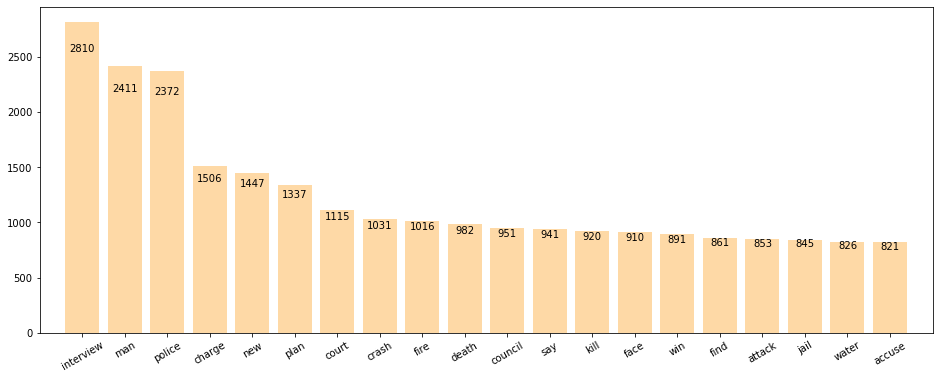

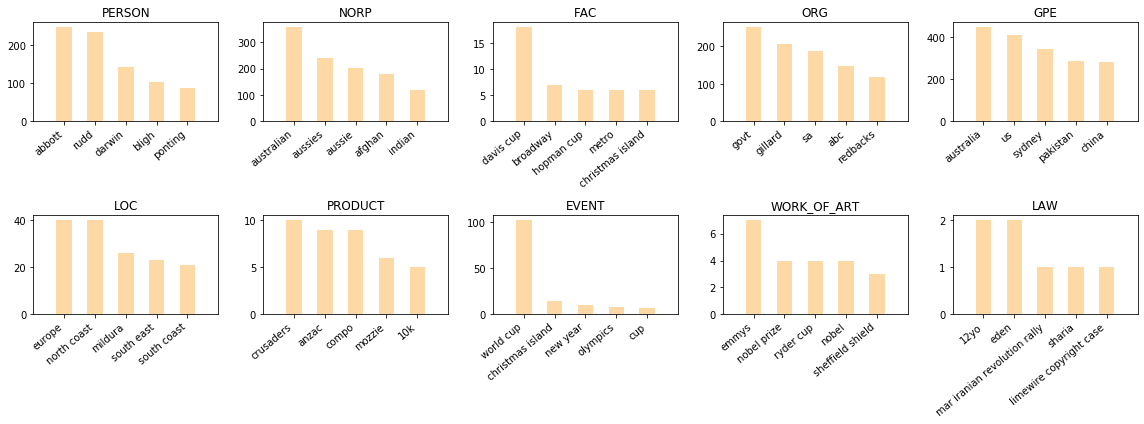

Year: 2011


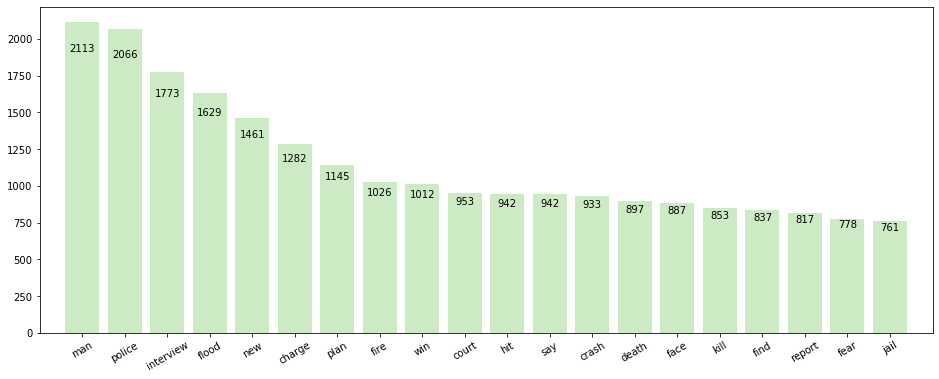

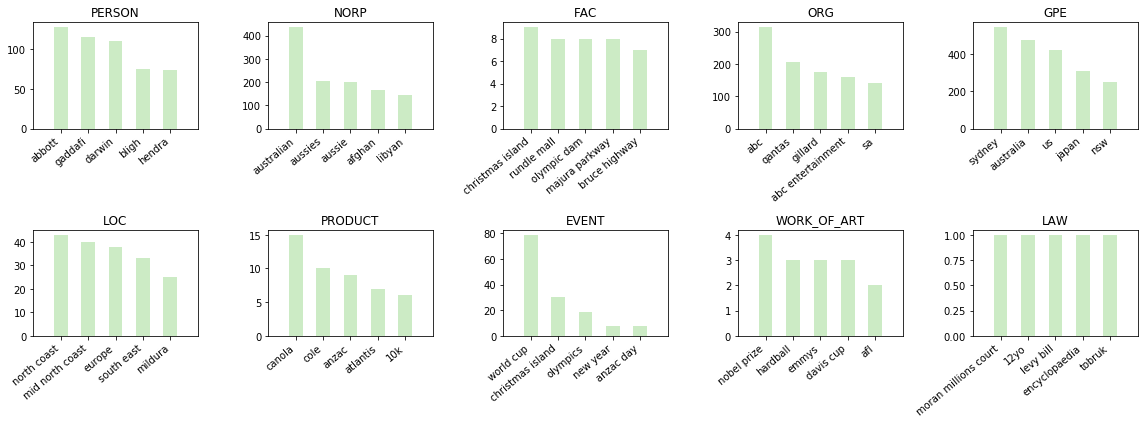

Year: 2012


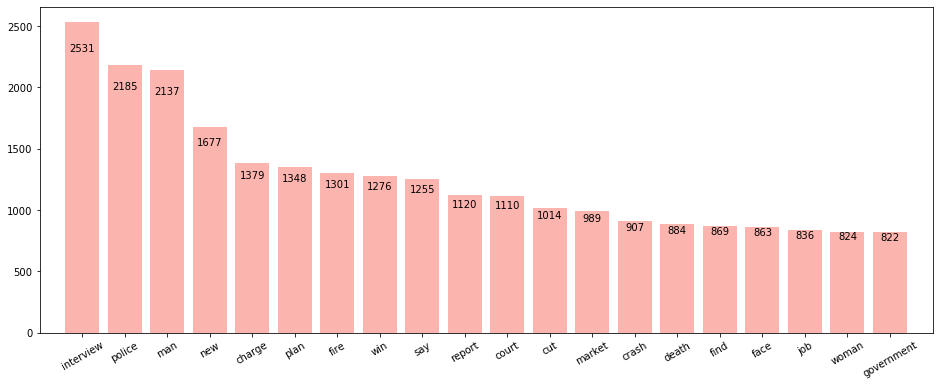

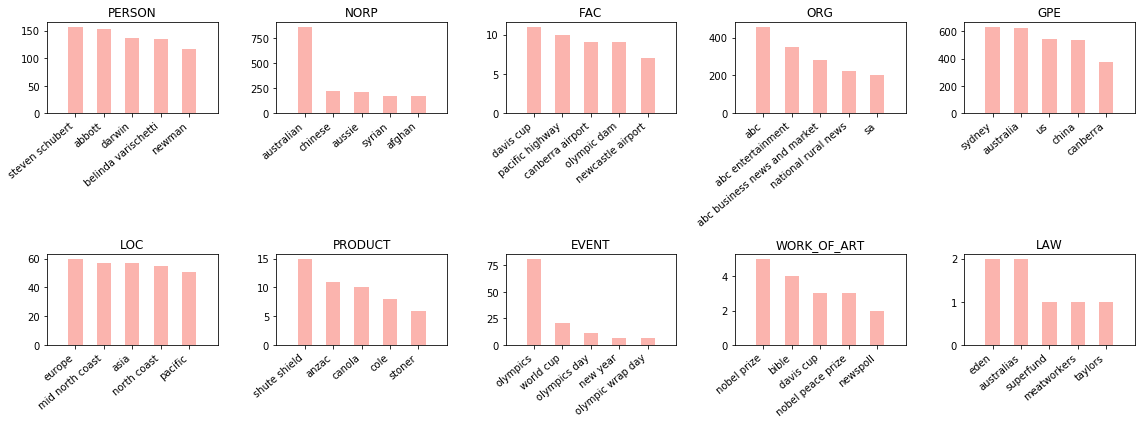

Year: 2013


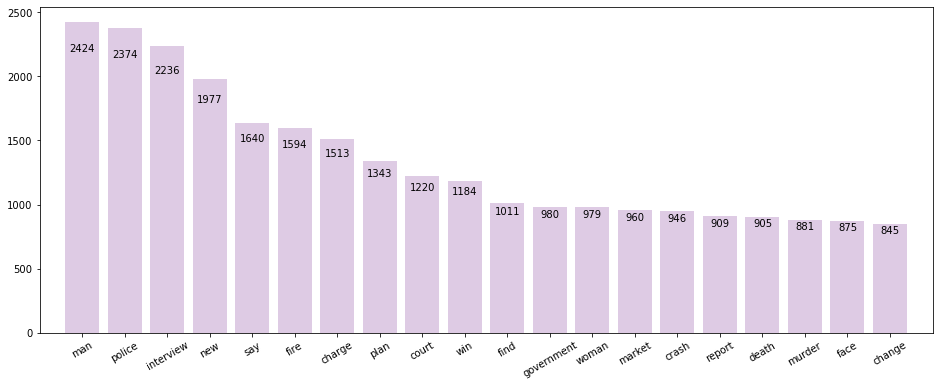

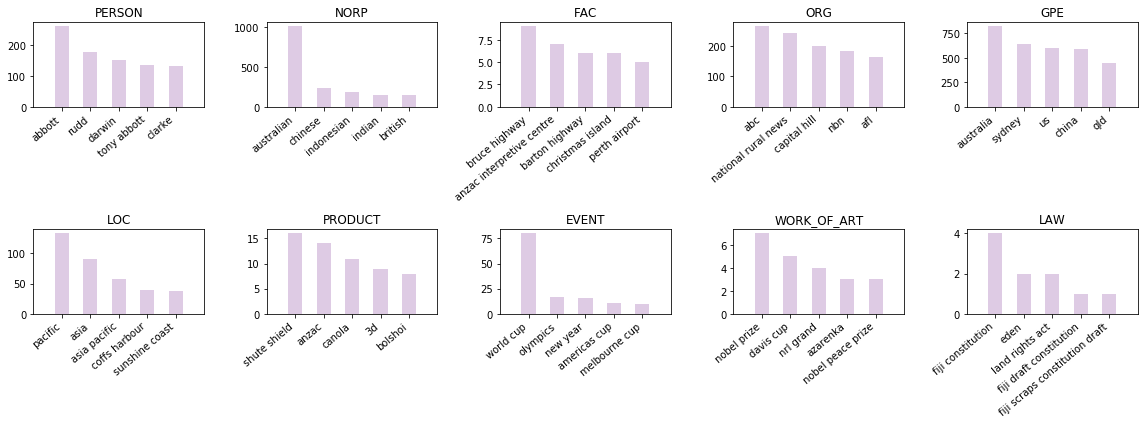

Year: 2014


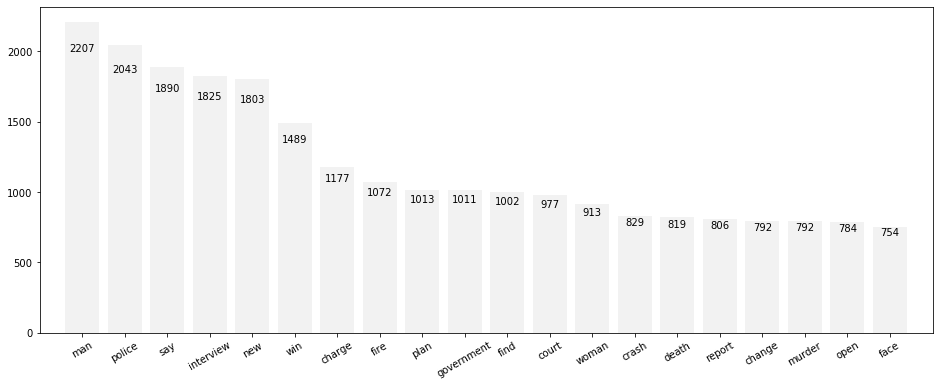

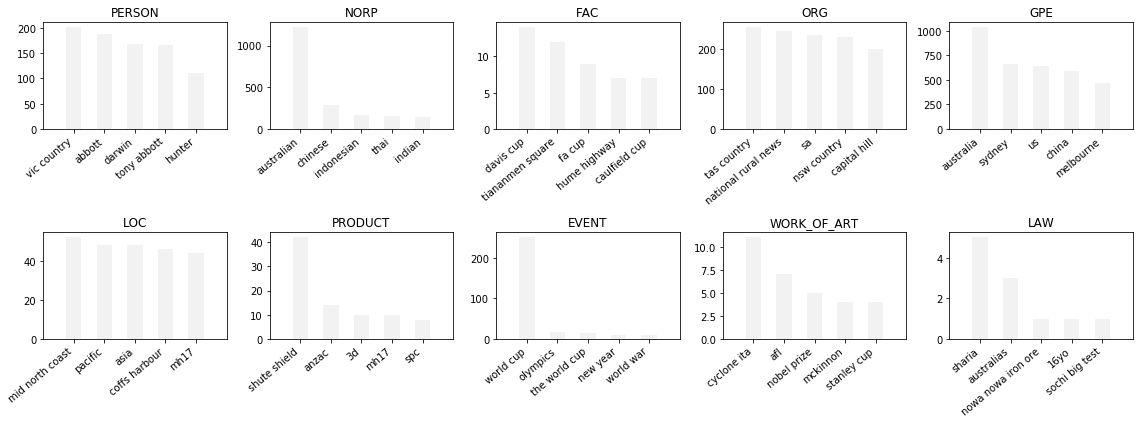

Year: 2015


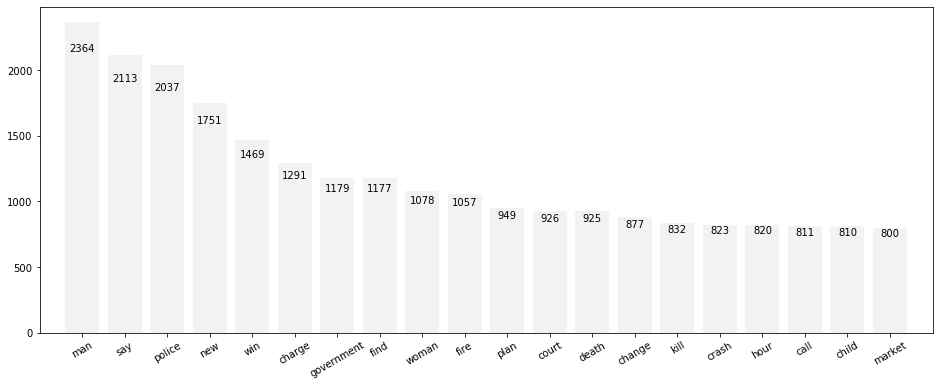

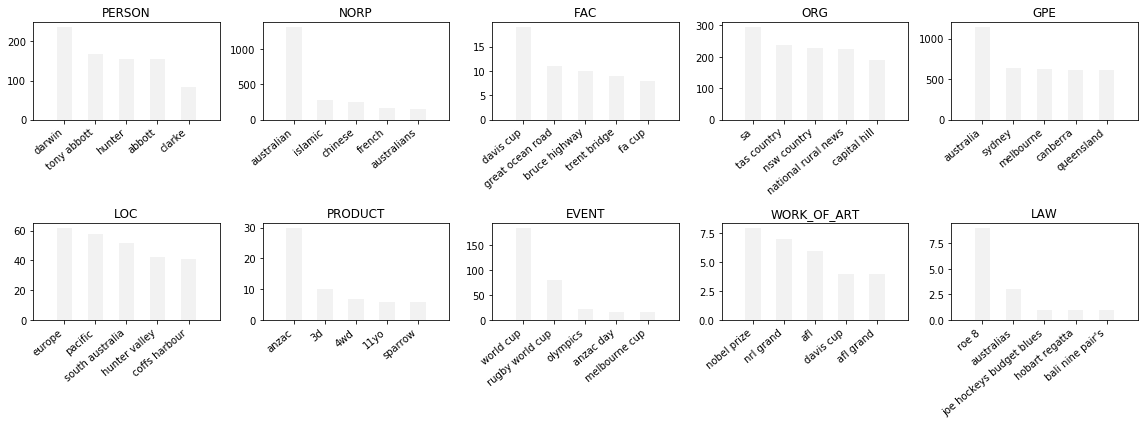

Year: 2016


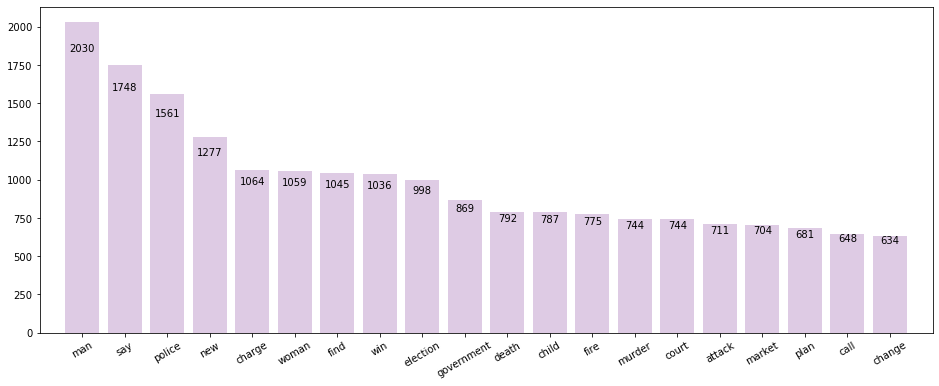

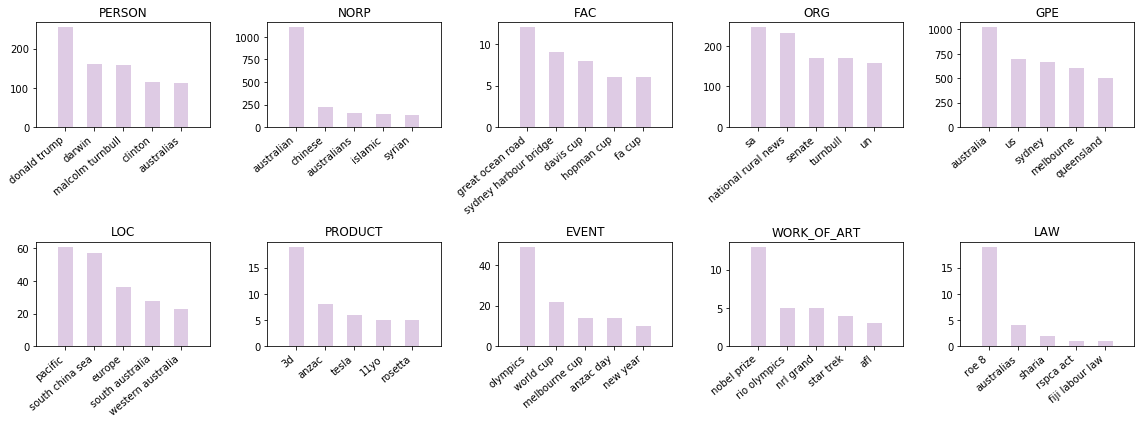

Year: 2017


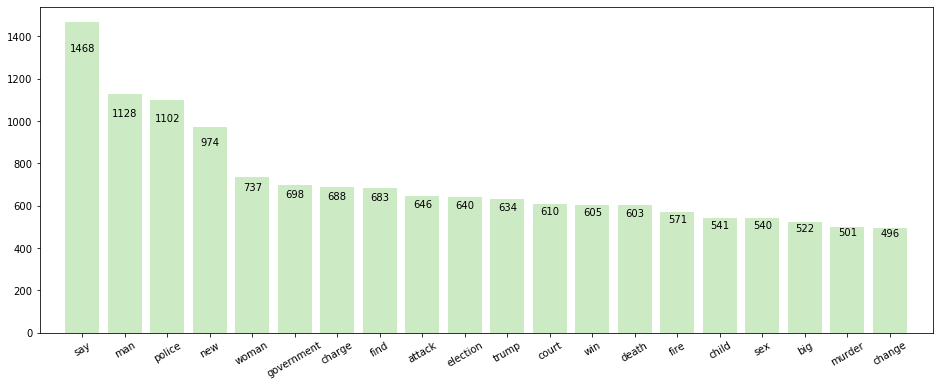

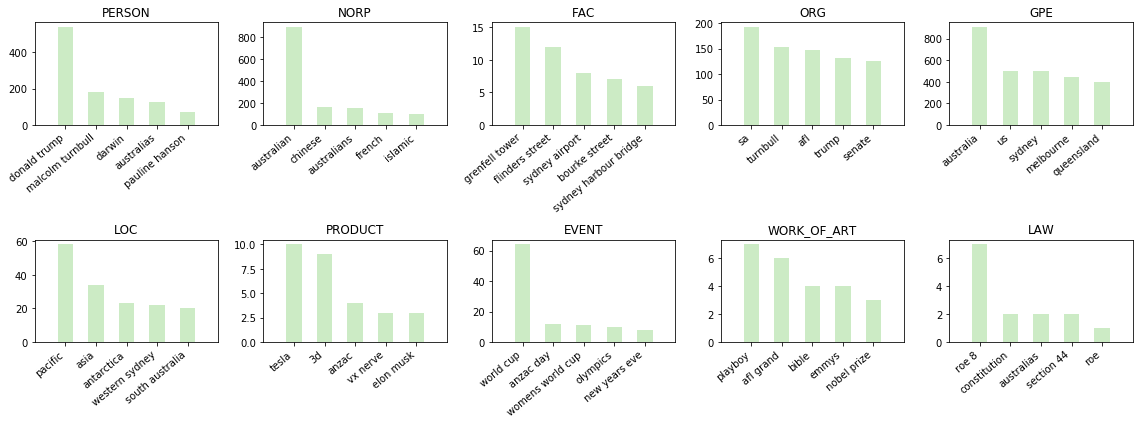

Year: 2018


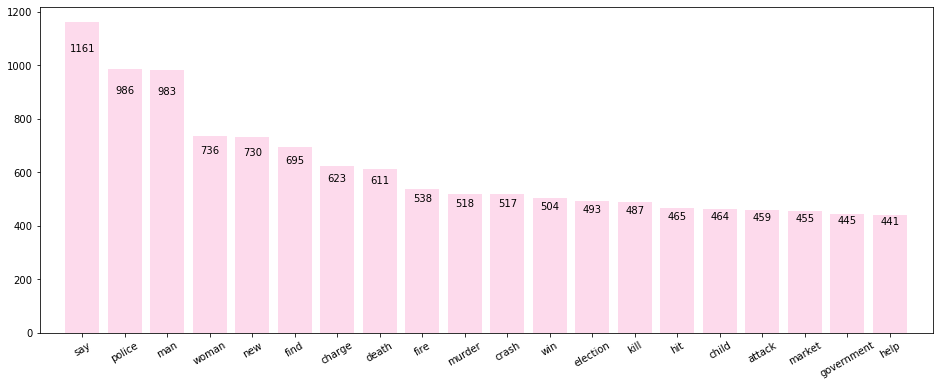

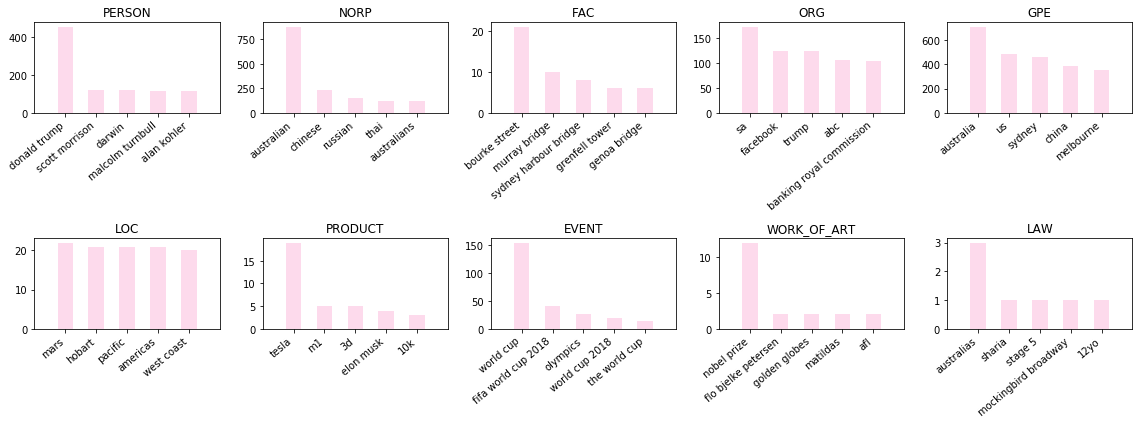

Year: 2019


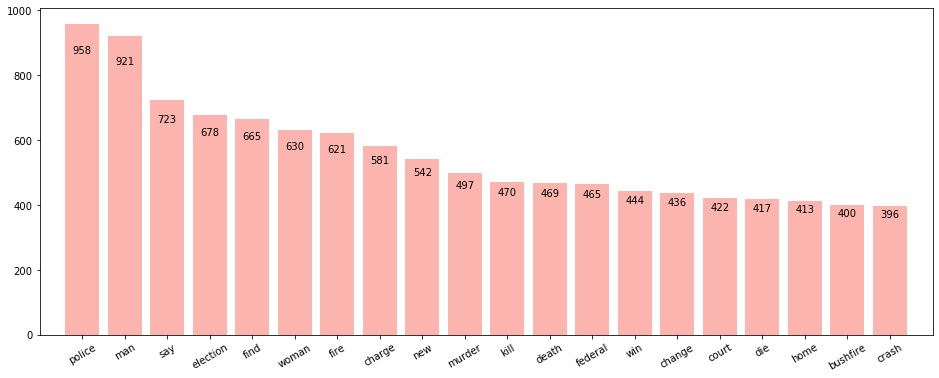

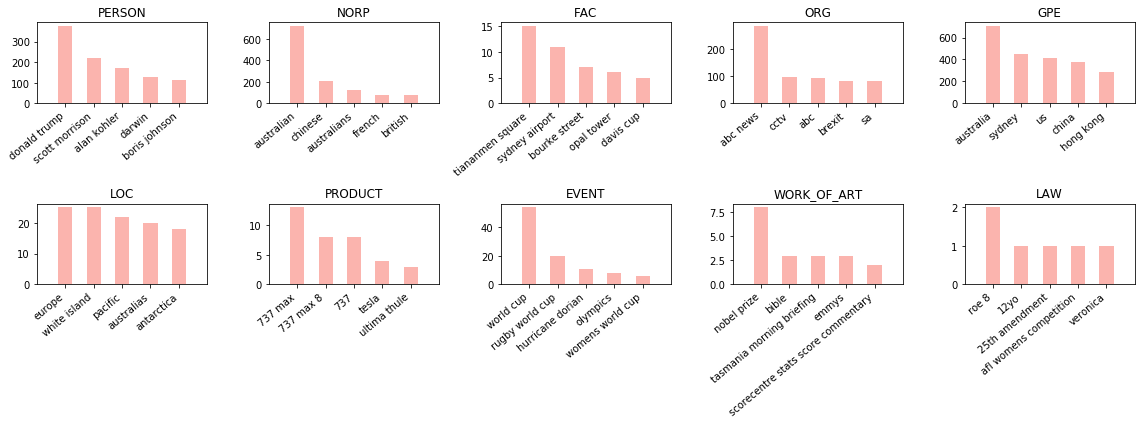

In [15]:
import warnings
warnings.filterwarnings("ignore")

for i in range(len(word_count_per_year)):
    period_color= plt.cm.get_cmap("Pastel1")(random.random())
    print('Year: {0}'.format(2010+i))
    dictionary = word_count_per_year[i][0]
    named_entities_dict = word_count_per_year[i][1]
    summary_plot(dictionary, named_entities_dict, period_color)
    display(HTML("<font color=\"red\">"+''.join(['-' for i in range(200)])+"</font>"))

The following function is used to search for ambiguous word, to clarify its true meaning

In [16]:
def search_nkeyword(word, listOfstring, n = 5):
    for s in listOfstring:
        str_set = set(s.split(' '))
        if(all([w in str_set for w in word])):
            print(s)
            n -= 1
        if(n == 0):
            break

Now we have the most frequent words and useful entities. We will use frequent words as the theme and entities as the auxiliary to draw the hot topics per years. 

Remember, these are annual summaries. The low-frequency words or entities may be distributed throughout the year which means low attractive. Therefore, we will ignore words or entities with a frequency below 60.


#### 2010 

In [17]:
search_nkeyword(['interview'], headline_for_years[0])

interview jelena dokic
interview simon katich and shane watson
interview david hussey
interview dominic thornely
interview greg shipperd


In [18]:
search_nkeyword(['new'], headline_for_years[0])

600 hurt in philippine new year revelry
happy new year
most new years eve revellers well behaved police
new mines needed for coal expansion
new sustainability declaration for home sellers


In [19]:
search_nkeyword(['fire'], headline_for_years[0])

a bad day on the water and statewide fire watch
toodyay fire probe begins
donor helps toodyay fire victims
residents evacuate as fire threatens homes
threat eases from deliberately lit fire


In [20]:
search_nkeyword(['darwin'], headline_for_years[0])

renters feeling the pinch in darwin
darwin misses out on international cricket
first train in 10 days to top up darwin supplies
rudd to open darwin cancer treatment centre
phone lines down at royal darwin hospital


In [21]:
search_nkeyword(['bligh'], headline_for_years[0])

bligh urged to visit mary valley
bligh is back
bligh set to commission water pipeline
record spending on schools this year bligh
bligh govt rushed signing gold coast race langbroek


In [22]:
search_nkeyword(['ponting'], headline_for_years[0])

interview ricky ponting
ponting concerned over shield future
interview ricky ponting
interview ricky ponting
australias victory was ponting personified


In [23]:
search_nkeyword(['redbacks'], headline_for_years[0])

afridi fires as redbacks haul in bulls
twenty20 summary redbacks vs bulls
redbacks opt for aerial assault
redbacks to make use of friendly deck
redbacks vs bushrangers twenty20 summary


In [24]:
search_nkeyword(['world', 'cup'], headline_for_years[0])

aussie u19s into world cup semis
afl star serves up tennis world cup ace
deans still the man for world cup
world cup striker critical after shooting
marsh bats aussies into world cup decider


In [25]:
search_nkeyword(['cctv'], headline_for_years[0])

cctv footage shows alleged atm skimmers
privacy fears spark cctv petition
cctv captures baghdad blast
cctv footage of baby falling on train tracks
cctv captures violent robbery


1. Criminal activity:\
police, charge, court, crash, death, council, kill, attack, jail, accuse
2. disasters:\
fire
3. political\
abbott(28th Prime Minister of Australia)\
Rudd(26th Prime Minister of Australia)\
gillard(27th Prime Minister of Australia)\
Bligh(37th Queensland Premier)
4. sport\
interview\
Ponting(cricket)\
redbacks (cricket)\
win\
world cup
5. local:\
sydney, darwin
6. international:\
us, pakistan, china
7. nation of people:\
afghan, indian


#### 2011

In [26]:
search_nkeyword(['fear'], headline_for_years[1])

copts living in fear after egyptian bloodbath
police fear mcdonalds bandits will strike again
police fear for missing 15yo girl
teens have no fear due to brain changes study
suburb haunted by fear of looters


In [27]:
search_nkeyword(['hit'], headline_for_years[1], 10)

police officer hit with bottle at st kilda
man dies after alleged hit and run
northern argentina hit by 70 quake
teen hit by lightning rescued from mountain
aussies hit back at scg
bail for new years day hit run accused
flood hit st george evacuates residents
wagga base hospital beds hit by nurses dispute
drought hit women given tennis trip
floods to hit mining sector hard


In [28]:
search_nkeyword(['gaddafi'], headline_for_years[1])

berlusconi wont disturb gaddafi amid bloodshed
analysis gaddafi will fight to the bitter end
gaddafi denies fleeing libya amid revolt
gaddafi under siege as cities overrun
gaddafi under siege as revolt hits tripoli


In [29]:
search_nkeyword(['hendra'], headline_for_years[1])

hendra stigma cripples horse stud
hendra virus season approaches
hendra virus kills horse near brisbane
up to 8 people exposed to hendra virus
vets calls for mandatory hendra vaccinations


In [30]:
search_nkeyword(['qantas'], headline_for_years[1])

qantas flight grounded after wing problem
qantas a380s to fly to la again
qantas settles price fixing suit
engine failure grounds qantas 747
qantas plane struck by lightning in broome


In [31]:
search_nkeyword(['bligh'], headline_for_years[1])

bligh calls flood crisis cabinet meeting
the queensland premier anna bligh addresses a
this weather will not break our will bligh
bligh gillard warn against travel as floodwaters
bligh makes emotional plea as floods devastate


1. Criminal activity:\
police, charge, court, hit, crash, death, kill, fear, jail
2. disasters:\
fire, flood, hendra virus
3. political\
abbott(28th Prime Minister of Australia)\
gillard(27th Prime Minister of Australia)\
Bligh(37th Queensland Premier)\
Gaddafi(Libyan leader Moamar)
4. sport\
interview\
win\
world cup
5. local:\
sydney, darwin, nsw
6. international:\
us, japan
7. nation of people:\
afghan, libyan


### 2012

In [32]:
search_nkeyword(['new'], headline_for_years[2])

a quiet new year's for perth
lendl becomes murray's new coach
man impales leg during new year celebrations
mint produces new coin
new year welcomed around the world


In [33]:
search_nkeyword(['plan'], headline_for_years[2])

syrian opposition signs plan for post assad future
obama to unveil more realistic military plan
power shutdown bushfire plan
ramsar plan stalls for menindee
rural road speed limit plan defended


In [34]:
search_nkeyword(['report'], headline_for_years[2])

report says mining industry facing unprecedented
kohler report
2011 weather report card 3rd wettest on record
annual climate report
kohler report


In [35]:
search_nkeyword(['cut'], headline_for_years[2])

etsa defends power cut decision
etsa power cut compensation
was biggest grain producer to cut crop
menindee cut off by flood waters
flood cut council


In [36]:
search_nkeyword(['market'], headline_for_years[2])

abc business news and market analysis
abc business news and market analysis
abc business news and market analysis
market outlook am
tassie hay harvest dampens fodder market


In [37]:
search_nkeyword(['face'], headline_for_years[2])

frenchman to face court charged with murder
rock climber stuck on cliff face
man to face court after girls death
man hit in face with bottle
whaling activists face uncertain future


In [38]:
search_nkeyword(['steven', 'schubert'], headline_for_years[2],5)

steven schubert speaks about the contract to sell
steven schubert speaks to paul purdon from nretas
steven schubert speaks to dr jeremy russell smith
steven schubert speaks to justin and colleen
steven schubert speaks to ian mcbean am at his


In [39]:
search_nkeyword(['belinda', 'varischetti'], headline_for_years[2],5)

belinda varischetti speaks with terri sanders
belinda varischetti interviews david stoate
belinda varischetti interviews andrew burton
belinda varischetti interviews carina kopke
belinda varischetti interviews reporter richard


In [40]:
search_nkeyword(['newman'], headline_for_years[2],5)

interview with campbell newman
newman pushes for election date with countdown clock
grylls checks newman town centre progress
newman denies latest property claims
newman rules out katter coalition


1. Criminal activity:\
police, charge, court, crush, death, face
2. disasters:\
fire
3. political\
plan, report, cut, market, government\
abbott(28th Prime Minister of Australia)\
Campbell Newman(38th Premier of Queensland)
4. sport\
interview, win, olympics
5. local:\
sydney, darwin, canberra
6. international\
US, china
7. nation of people:\
ausutralian, chinese, aussie, syrian, afghan


### 2013

In [41]:
search_nkeyword(['rudd'], headline_for_years[3],5)

have a heart and boost dole rudd
rudd calls for compassion on dole
rudd looks back at brisbane floods
rudd calls for arming of syrian opposition
rudd calls on world to arm syrian rebels


In [42]:
search_nkeyword(['clarke'], headline_for_years[3],5)

clarke gets through scg fitness test
clarke names four prong pace attack for scg
interview michael clarke
interview michael clarke
clarke presented mcgilvray medal


In [43]:
search_nkeyword(['capital', 'hill'], headline_for_years[3],5)

capital hill 5 february 2013
capital hill monday 4 february 2013
capital hill wednesday 6 february 2013
capital hill thursday 7 february 2013
capital hill friday 8 february 2013


In [44]:
search_nkeyword(['pacific'], headline_for_years[3],10)

holiday travellers stuck in pacific highway jams
giant squid filmed in pacific depths
truck hits pacific highway safety barrier near urunga
japan to survey pacific seabed for rare earth
radio australias james oaten speaks to pacific beat
mahendra chaudhry speaks to pacific beat
asia pacific interviews unhcrs vivian tan
lawyer rajendra chaudhry speaks to pacific beat
businesswoman sarah haoda todd speaks to pacific
delays on pacific highway after truck accident


1. Criminal activity:\
police, charge, court, crash, death, murder
2. Natural disasters:\
fire
3. political\
plan, government, report, change, nbn, pacific highway \
abbott(28th Prime Minister of Australia)\
Kevin Rudd(26th Prime Minister of Australia)
4. sport\
interview\
Michael Clarke(cricket)\
afl\
world cup
5. local\
sydney, darwin, qld
6. international\
us, china, asia, pacific island
7. nation of people:\
ausutralian, chinese, indonesian, indian, british


### 2014

In [45]:
search_nkeyword(['vic'],headline_for_years[4])

vic country hour 1 january 2014
vic country hour 2 january 2014
vic country hour 3 january 2014
two dead in vic road crash
syringe vending machine trial backed by vic minister


In [46]:
search_nkeyword(['hunter'],headline_for_years[4])

big increase in hunter air pollution
investigations into chemical levels in hunter river
scientific committee says hunter herb is vulnerable species
epa investigates hunter water discharge into local creek
rfs crews brought in to contain two upper hunter fires


1. Criminal activity:\
police, charge, court, crash, death, murder
2. disasters:\
fire
3. political\
plan, government, report, change
abbott(28th Prime Minister of Australia)\
Campbell Newman(38th Premier of Queensland)
4. sport\
world cup
5. local:\
sydney, hunter, melbourne
6. international\
US, china
7. nation of people:\
ausutralian, chinese, indonesian, thai, indian


### 2015

In [47]:
search_nkeyword(['call'],headline_for_years[5])

melbourne nye paramedics 150 call outs illegal fireworks
sa dairy farmers call for stricter regulations on raw milk
call for torres strait climate change plan
call to action after sniffing death in nt
queensland premier expected to call snap election


In [48]:
search_nkeyword(['child'],headline_for_years[5])

man charged with trying to procure a child
gary glitter on trial for child sex abuse
mount nelson man shaun cousins denies child sex offences
bendigo child health centre plans get green light
china australia businessman pleads not guilty to child sex


In [49]:
search_nkeyword(['clarke'],headline_for_years[5])

clarke and dawe the duke of edinburgh day honours
clarke to play sydney grade cricket this weekend
michael clarke denies rift in australian camp after making sydn
i would play under steve smith: clarke
clarke on track to captain australia at cricket world cup


1. Criminal activity:\
police, charge, court, deatg, kill, crash, child
2. disasters:\
fire
3. political\
government, plan, market, change\
abbott(28th Prime Minister of Australia)\
4. sport\
win
world cup
Michael Clarke(cricket)
5. local:\
sydney, darwin, hunter, melbourne, canberra, queensland
6. international\
europ
7. nation of people:\
ausutralian, islamic, chinese, french
8. normal\
new

### 2016

In [50]:
search_nkeyword(['clinton'],headline_for_years[6])

clinton attacks sanders on gun control record
sanders clinton democratic final debate live coverage
top secret emails on clinton server no public release
clinton sanders face off in new hampshire debate
us election hillary clinton bernie sanders debate iowa


In [51]:
search_nkeyword(['senate'],headline_for_years[6])

gun control barack obama plans to bypass senate
victorian liberals push for all female senate ticket
nick xenophon in wa to campaign for team senate spot
children with disabilities failed by education system senate
sydney university senate accused of making changes in secret


In [52]:
search_nkeyword(['turnbull'],headline_for_years[6])

maccallum shorten will need more than bluster to answer turnbull
malcolm turnbull rules out investigation into photo leak briggs
turnbull innovation ad campaign to cost taxpayers 28 million
malcolm turnbull to meet with barack obama on january 19
malcolm turnbull moving in to the lodge


1. Criminal activity:\
police, charge, find, death, child, murder, court, attack, charge
2. disasters:\
fire
3. political\
election, government, market, plan, senate\
donald trump\
Hillary Clinton\
malcolm turnbull(29th Prime Minister of Australia)
4. sport\
olympics
5. local:\
sydney, darwin, melbourne, queensland
6. international\
US, pacific, south china sea
7. nation of people:\
australian, chinese, islamic, syrian


### 2017

In [53]:
search_nkeyword(['pauline'],headline_for_years[7])

one nation pauline hanson dumps anti gay candidate shan ju lin
lnp mp steve dickson defects to pauline hansons
wa election pauline hanson in perth one nation campaign launch
wa election pauline hanson unveils one nation candidates
wa election one nation pauline hanson campaigns in south west


In [54]:
search_nkeyword(['win'],headline_for_years[7])

usain bolt call mutv to celebrate manchester united win
destanee aiava upset win at brisbane international tennis
dele alli double gives spurs 2 0 win over chelsea
ivan franjic stunner gives melbourne city a league win
powercharged powers home to win devonport cup


In [55]:
search_nkeyword(['big'],headline_for_years[7])

perth scorches v sydney thunder big bash league
big demand for on farm stoarge from grain growers
nt teen cricketer tabatha saville makes her big bash debut
prominent fisherman calls big salmon farms unsustainable
sixers beat the heat in big bash


1. Criminal activity:\
police, charge, attack, court, dead, sex, murder
2. disasters:\
-
3. political\
change\
donald trump\
malcolm turnbull(29th Prime Minister of Australia)\
Pauline Hanson(Senate)
4. sport\
win, afl, world cup
5. local:\
sydney, darwin, melbourne, queensland
6. international\
US, oacific
7. nation of people:
australian, chinese, french, islamic

### 2018

In [56]:
search_nkeyword(['help'],headline_for_years[8])

dubbo coral sperm bank could help safeguard great barrier reef
tourists should prove driving skills to help cut road toll: mp
online program aims to help youth who drink due to anxiety
long range wifi to track dementia patients and help farmers
how to help dogs afraid of top end storms


In [57]:
search_nkeyword(['alan'],headline_for_years[8])

alan kohlers take on the days panic on stock markets
alan finkel speaks to the business
alan jones defamation case wagner family grantham floods
alan jones in court
alan jones media outlets face record defamation claim


1. Criminal activity:\
policem charge, death, murder, crash, kill, attack
2. disasters:\
fire
3. political\
election, markey, government\
donald trump\
scott morrison(30th Prime Minister of Australia)\
malcolm turnbull(29th Prime Minister of Australia)

4. sport\
win, world cup
5. local:\
Sydney, melbourne, darwin
6. international\
US, china
7. nation of people:\
australian, chinese, russian, tai

### 2019

In [58]:
search_nkeyword(['federal'],headline_for_years[9])

david leyonhjelm quits federal politics to run in nsw election
syphilis outbreak federal government failure australian medical
donald trump walks out of us federal shutdown talks
victorian politics in federal election year
federal government australia day citizenship local councils


In [59]:
search_nkeyword(['alan'],headline_for_years[9])

tuesday finance with alan kohler
wednesday finance with alan kohler
thursday finance with alan kohler
monday finance with alan kohler
tuesday finance with alan kohler


In [60]:
search_nkeyword(['boris'],headline_for_years[9])

boris the dog survives skewer puncture to heart
theresa may to set departure timetable as boris johnson throws
boris johnson the frontrunner to replace theresa
uk pm candidate boris johnson to face court over brexit comments
boris johnson to face court over brexit allegations


1. Criminal activity:\
police, charge, murder, kill, death, charge, court, die, crash
2. disasters:\
bushfire
3. political\
federal, brexit\
donald trump\
scott morrison(30th Prime Minister of Australia)\
Boris Johnson(Prime Minister of the United Kingdom)
4. sport\
win
5. local:\
Sydney, darwin
6. international\
US, china, hong kong
7. nation of people:\
australian, chinese, french, british

We have built the introduction to the hot topics of the past decade. The common of these topics can indicate the interest of Australian. Therefore, we will summarise these topics in the next section. 

## Insight

Australian seems very concerned about their community, we can notice that ABC news uses a lot of space to describe someone is being hurt. Criminal activity is one of the instances, especially with keywords police, charge, court, crash, death. Disasters are the other one which has keywords flood and bushfire.

Australian also focus on politics. For local, election, changes, plan, market are the most common keywords. Prime Minister of Australia is always in the popular list. People also pay special attention to some location includes Sydney, Darwin and Queensland.

For international, breaking news could catch the attention as well, for example, 2016 us presidential election, 2019 Brexit process, 2019 hong kong turmoil and US-China trade war. Moreover, the U.S., China and Asia seem to always on the watch list.


Sport is also an important topic. Australian very concerned about the win, since it is the hot keyword over the last decade. Large sport event is the eyebrow catcher in especially cricket and Olympics

It is worth noting that Australian shows the attention to nation of people includes Chinese, French, British, Islamic, French, Indonesian, Thai, Indian, Afghan.